In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [12]:
# Hyper parameters and optimization parameters


########################################
# LEARNING RATE (alpha) related settings
INITIAL_LEARNING_RATE = 0.03

# LEARNING DECAY settings
DECAY_STEPS = 10      # After this many steps, learning_rate will be = learning_rate * decay_rate
DECAY_RATE = 1.       # if decay_rate=1.  then it means learning decay is not applied
########################################

########################################
# GENERAL model params
NUM_TRAIN_EPOCHS = 80      # Let this be a multiple of EPOCH_PERIOD_TO_SAVE_COST
MINIBATCH_SIZE = 8
EPOCH_PERIOD_TO_SAVE_COST = DECAY_STEPS   # After how many epochs do you want to save cost & accuracy?
########################################

########################################
# NN Architecture
NUM_CLASSES = 2
NUM_UNITS_IN_LAYERS = [5, 6, NUM_CLASSES] 
########################################

########################################
# DROPOUT settings
NO_DROPOUT_IN_INPUT_LAYER = 0.   # Setting the layer dropout_rate=0 will deactivate dropout in that layer
NO_DROPOUT_IN_OUTPUT_LAYER = 0.
# You only apply dropout in hidden layers. E.g. if rate=0.1 for a layer, 0.1 of units in that layer is dropped out
DROPOUT_RATES_PER_LAYER = [NO_DROPOUT_IN_INPUT_LAYER, 0., NO_DROPOUT_IN_OUTPUT_LAYER]    
########################################

########################################
# REGULARIZATION settings
LAMBD = 0.     # regularization parameter lambda
########################################

########################################
# BATCH NORMALIZATION settings - also helps regularizing
NORMALIZE_BATCH = False
MOVING_AVG_MOMENTUM = 0.99   # irrelevant if NORMALIZE_BATCH = False
########################################

########################################
# INPUT (LAYER) NORMALIZATION
NORMALIZE_INPUT = False
########################################

########################################
# Utils
PRINT_PROGRESS = True
########################################

########################################
# Train/Dev/Test data may reside in several files.
train_path1 = "train1.csv"
train_path2 = "train2.csv"
dev_path1 = "dev1.csv"
test_path1 = "test1.csv"
TRAIN_INPUT_PATHS = [train_path1, train_path2]
DEV_INPUT_PATHS = [dev_path1]
TEST_INPUT_PATHS = [test_path1]

# UPDATE-1 IN EACH PROJECT (depending on default values for each column)
# Determine default values for each column in case data is missing
RECORD_DEFAULTS = [[""], [0.0], [0.0], [0.0], [0.0], [0.0], [0]]

NUM_FEATURES = len(RECORD_DEFAULTS) - 2
########################################

In [13]:
# FUNCTION: Returns the tf variable if exists. Otherwise creates a new one.
# Example call:   tf_variable = get_tf_variable(...)
def get_nn_parameter(variable_scope, variable_name, dim1, dim2):
    '''
    Used to retrieve or create new NN parameters (weights & biases)
    When calling, the corresponding NNparameter's dimensions need to be specified too.
    Returns a tensorflow variable. Note that NN parameters need to be tensorflow variables
    so that values can be changed whenever needed when training. Also note that it is 
    explicitly defined that the created variable is TRAINABLE.
    '''
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      v = tf.get_variable(variable_name, 
                          [dim1, dim2], 
                          trainable=True, 
                          initializer = tf.contrib.layers.xavier_initializer())
    return v

In [14]:
# Initialize NN params before starting the training
def initialize_layer_parameters():
    '''
    Exmaple return: parameters = {"W1": tf_variable_for_W1, "b1": tf_variable_for_b1, ...}
    '''
    
    parameters = {}
    L = len(NUM_UNITS_IN_LAYERS)
     
    for i in range (1, L):
        #print("W" + str(i) + " " + str(NUM_UNITS_IN_LAYERS[i]) + " " + str(NUM_UNITS_IN_LAYERS[i-1]))
        temp_weight = get_nn_parameter("weights",
                                       "W"+str(i), 
                                       NUM_UNITS_IN_LAYERS[i], 
                                       NUM_UNITS_IN_LAYERS[i-1])
        parameters.update({"W" + str(i) : temp_weight})  
        
        #print("b" + str(i) + " " + str(NUM_UNITS_IN_LAYERS[i]) + " " + str(1))
        temp_bias = get_nn_parameter("biases",
                                     "b"+str(i), 
                                     NUM_UNITS_IN_LAYERS[i], 
                                     1)
        parameters.update({"b" + str(i) : temp_bias})  
        
    return parameters

In [15]:
def forward_propagation_with_relu(X, training):

    # X has the shape (num_features, num_examples), where num_examples = MINIBATCH_SIZE
    
    L = len(NUM_UNITS_IN_LAYERS)

    
    if NORMALIZE_INPUT:
        input_norm_mu = get_input_norm_parameter("input_norm_scope", 
                                                 "input_norm_mu", 
                                                 1, NUM_FEATURES)
        input_norm_sigma_square = get_input_norm_parameter("input_norm_scope", 
                                                           "input_norm_mu", 
                                                           1, NUM_FEATURES)        
        X = tf.divide(tf.subtract(X, input_norm_mu), 
                      input_norm_sigma_square)
    
    A_temp = tf.transpose(X)
    
    for i in range (1, L):
        W = get_nn_parameter("weights",
                             "W"+str(i), 
                             NUM_UNITS_IN_LAYERS[i], 
                             NUM_UNITS_IN_LAYERS[i-1])

        b = get_nn_parameter("biases",
                             "b"+str(i), 
                             NUM_UNITS_IN_LAYERS[i], 
                             1)

        Z_temp = tf.add(tf.matmul(W, A_temp), b)
        if NORMALIZE_BATCH:
            if (i < (L-1)):    # Do NOT batch normalize the output layer 
                with tf.variable_scope("batch_norm_scope", reuse=tf.AUTO_REUSE):
                    Z_temp = tf.layers.batch_normalization(Z_temp, axis=0, 
                                                           training=training,
                                                           momentum=MOVING_AVG_MOMENTUM)

        A_temp = tf.nn.relu(Z_temp)
        if (i < (L-1)):     # Do NOT apply dropout in output layer
            A_temp = tf.layers.dropout(A_temp, rate=DROPOUT_RATES_PER_LAYER[i], training=training)
            
    batch_predictions = tf.argmax(Z_temp, 0, name="batch_predicted_classes")

    return batch_predictions, Z_temp   #This is the linear output of last layer

In [16]:
# FUNCTION
# This function requires update if softmax is not used in the output layer
def compute_cost(ZL, Y):
    """
    This function should be used for multinomial mutually exclusive classification, i.e. pick one out of N classes. 
    Also applicable when N = 2.
    The labels must be one-hot encoded or can contain soft class probabilities: a particular example can belong to
    class A with 50% probability and class B with 50% probability. Note that strictly speaking it doesn't mean that
    it belongs to both classes, but one can interpret the probabilities this way.
    
    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)      # ZL.shape = (num_features x MINIBATCH_SIZE)
    labels = tf.squeeze(tf.one_hot(Y, NUM_CLASSES), 1)
    
    # This cost calculation is unregularized. cost = (1/m) sum(Loss(y_hat(i), y(i))), where i = 1,..,mb_size 
    #tf.reduce_mean(..) function finds the mean of costs of examples in the given mini-batch
    cost_unregularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    # Add L2 regularization: cost += (LAMBD / (2 * MINIBATCH_SIZE)) * sum(W(i,j)**2), 
    # where i:1,..,n[l] and j:1,..,n[l-1] 
    # L:number of layers (except input layer). 
    L = len(NUM_UNITS_IN_LAYERS)
    
    # The list will have L elements, each holding the sum of weight matrix values in each layer. Later, these
    # weight values need to be summed up again
    list_sum_weights = []
    
    for i in range (1, L):
        W = get_nn_parameter("weights",
                             "W"+str(i), 
                             NUM_UNITS_IN_LAYERS[i], 
                             NUM_UNITS_IN_LAYERS[i-1])
        list_sum_weights.append(tf.nn.l2_loss(W))
    
    # in the following calculation, since the l2_loss returns "sum(t ** 2) / 2", where the sum of squares is already
    # divided by 2, there is no need to bultiply the mb_size with 2
    #regularization_effect = (LAMBD / MINIBATCH_SIZE) * sum(list_sum_weights)
    regularization_effect = tf.multiply((LAMBD / MINIBATCH_SIZE), tf.add_n(list_sum_weights))
    cost = tf.add(cost_unregularized, regularization_effect)
    
    return cost

In [17]:
# FUNCTION: Returns the input normalization parameter mu / sigma_square.
# IF the variable does not exist, it creates a new one.

def get_input_norm_parameter(variable_scope, variable_name, dim1, dim2):

    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      input_norm_var = tf.get_variable(variable_name, 
                                       [dim1, dim2], 
                                       trainable=False, 
                                       initializer = tf.ones_initializer())
    return input_norm_var

In [18]:
# Retrive data from csv file

def decode_csv(line):
    parsed_line = tf.decode_csv(line, RECORD_DEFAULTS)
    label = parsed_line[-1:]          # last column is labels
    del parsed_line[-1]               # delete the last element from the list   (label column)
    del parsed_line[0]                # even delete the first element bcz it is assumed NOT to be a feature
    features = tf.stack(parsed_line)  # Stack features so that you can later vectorize forward prop., etc.
    label = tf.stack(label)           # Needed bcz labels consist of 2 columns
    batch_to_return = features, label

    return batch_to_return


In [19]:
def nn_model(mu, sigma_square):
    """
    Returns NN parameters after the completion of training.
    """

    tf.reset_default_graph()     # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)       # tf.reset_default_graph() needs to be run first before 
                                # calling tf.set_random_seed(..)
    
    costs_train = []                            
    accuracies_train = []
    costs_dev = []
    accuracies_dev = []
    precision_per_class = [0.] * NUM_CLASSES
    update_precision_per_class = [[]] * NUM_CLASSES
    recall_per_class = [0.] * NUM_CLASSES
    update_recall_per_class = [[]] * NUM_CLASSES
    f1_score_per_class = [0.] * NUM_CLASSES

    training = tf.placeholder(tf.bool)    



    with tf.name_scope("set_input_norm_params"):
        input_norm_mu = get_input_norm_parameter("input_norm_scope", 
                                                 "input_norm_mu", 
                                                 1, NUM_FEATURES)
        input_norm_sigma_square = get_input_norm_parameter("input_norm_scope", 
                                                           "input_norm_mu", 
                                                           1, NUM_FEATURES)    
    
        set_input_norm_mu = tf.multiply(input_norm_mu, 
                                        mu, 
                                        name="set_input_norm_mu")
        set_input_norm_sigma_square = tf.multiply(input_norm_sigma_square, 
                                                  sigma_square, 
                                                  name="set_input_norm_sigma_square")
    
    with tf.name_scope("init_nn_params"):
        # Initialize parameters
        parameters = initialize_layer_parameters()    

    with tf.name_scope("next_train_batch"):
        filenames = tf.placeholder(tf.string, shape=[None])
        dataset = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename).skip(1).map(decode_csv))
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(MINIBATCH_SIZE)
        iterator = dataset.make_initializable_iterator()
        X_mini_batch, Y_mini_batch = iterator.get_next()

    with tf.name_scope("forward_prop"):
        # Forward propagation: Build the forward propagation in the tensorflow graph
        batch_predictions, ZL = forward_propagation_with_relu(X_mini_batch, training)

    with tf.name_scope("calc_cost"):
        # Cost function: Add cost function to tensorflow graph
        cost_mini_batch = compute_cost(ZL, Y_mini_batch) 

    with tf.name_scope("learning_decay_scope"):
        # Global_step to use for the decay computation. Must not be negative.
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                                                   global_step, 
                                                   DECAY_STEPS,  
                                                   DECAY_RATE,  # how much will alpha be decayed?
                                                   staircase=False)        
        
    with tf.name_scope("train"):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):        
            # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
            optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_mini_batch,
                                                                                        global_step=global_step)        
    
    with tf.name_scope("metric_accuracy"):
        # Define the metric and update operations
        accuracy, accuracy_update = tf.metrics.accuracy(Y_mini_batch,
                                                        batch_predictions)

    with tf.name_scope("metric_precision_and_recall"):
        # Placeholders to take in batches of data
        tf_labels = tf.placeholder(dtype=tf.int64, shape=[Y_mini_batch.shape[0], 1])
        tf_predictions = tf.placeholder(dtype=tf.int64, shape=[batch_predictions.shape[0], ])         
        # NUM_UNITS_IN_LAYERS[-1] gives number of classes
        for k in range (NUM_CLASSES):
            precision_per_class[k], update_precision_per_class[k] = tf.metrics.precision(tf_labels, 
                                                                                         tf_predictions,
                                                                                         name="precision_class_"+str(k))
            recall_per_class[k], update_recall_per_class[k] = tf.metrics.recall(tf_labels, 
                                                                                tf_predictions,
                                                                                name="recall_class_"+str(k))    

    with tf.name_scope("reset_metric_variables"):
        # Isolate the variables stored behind the scenes by the metric operation
        accuracy_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metric_accuracy")
        precision_and_recall_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, 
                                                      scope="metric_precision_and_recall")
        #recall_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="metric_recall")
        metrics_var_list = accuracy_vars + precision_and_recall_vars #+ recall_vars
        # Define initializer to initialize/reset running variables
        tf_metrics_vars_initializer = tf.variables_initializer(var_list=metrics_var_list) 
        
    # Initialize all the variables
    init_global_var = tf.global_variables_initializer() 

    # Define a saver to save session params periodically
    saver = tf.train.Saver(max_to_keep=500)
    #saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=500)
    
    # sess is created fo the training phase
    with tf.Session() as sess:
        #print(sess.graph)
        sess.run(init_global_var)

        sess.run(set_input_norm_mu)
        sess.run(set_input_norm_sigma_square)
        
        epoch_nr = 0
        for _ in range(NUM_TRAIN_EPOCHS // EPOCH_PERIOD_TO_SAVE_COST): 
            # Train EPOCH_PERIOD_TO_SAVE_COST epochs. Then validate train set. Then validate dev set.
            for _ in range(EPOCH_PERIOD_TO_SAVE_COST):
                sum_minibatch_costs = 0
                nr_of_minibatches = 0
                sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
                sess.run(iterator.initializer, feed_dict={filenames: TRAIN_INPUT_PATHS})
                while True:
                    try:
                      _ , minibatch_cost, _ = sess.run([optimizer, 
                                                       cost_mini_batch, 
                                                       accuracy_update],
                                                       feed_dict={training: True})
                      nr_of_minibatches += 1
                      sum_minibatch_costs += minibatch_cost                   
                    except tf.errors.OutOfRangeError:
                      epoch_nr += 1
                      #print("Out of range error triggered (looped through training set 1 time)")
                      break
                    
            # Note that cost and accuracy reporting is done on the entire train set, not based on a subset
            current_cost_train = sum_minibatch_costs / nr_of_minibatches
            costs_train.append(current_cost_train)
            accuracies_train.append(sess.run(accuracy))
            if PRINT_PROGRESS:
                print ("TRAIN: After epoch %i: Cost: %f   Accuracy: %f" % 
                       (epoch_nr, current_cost_train, accuracies_train[-1]))
            
            
            # BEfore continuing training...
            # Now run validation on dev set to keep track of development (to later check bias/variance)

            sum_minibatch_costs = 0
            nr_of_minibatches = 0
            sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
            sess.run(iterator.initializer, feed_dict={filenames: DEV_INPUT_PATHS})
            while True:
                try:
                  minibatch_cost, _ = sess.run([cost_mini_batch, 
                                               accuracy_update],
                                               feed_dict={training: False})
                  nr_of_minibatches += 1
                  sum_minibatch_costs += minibatch_cost
                except tf.errors.OutOfRangeError:
                  #print("Out of range error triggered (looped through dev set 1 time only)")
                  break        
            # Note that cost and accuracy reporting is done on the entire dev set, not based on a subset
            current_cost_dev = sum_minibatch_costs / nr_of_minibatches
            costs_dev.append(current_cost_dev)
            accuracies_dev.append(sess.run(accuracy))
            if PRINT_PROGRESS:
                print ("DEV:   After epoch %i: Cost: %f   Accuracy: %f\n" % 
                       (epoch_nr, current_cost_dev, accuracies_dev[-1]))
    
            # Save the model periodically (after each EPOCH_PERIOD_TO_SAVE_COST epochs)
            dir = os.path.join("./checkpoint_dir", "my_nn_model")
            finfo = saver.save(sess, dir, global_step=epoch_nr)  
            #print(str(epoch_nr) + "  " + finfo + "\n")

        parameters = sess.run(parameters)
        
        # Training is completed at this point.
        #Calculate test set cost & accuracy. Improving test set cost is not the target here.Just further information..
        sum_minibatch_costs = 0
        nr_of_minibatches = 0
        sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
        sess.run(iterator.initializer, feed_dict={filenames: TEST_INPUT_PATHS})
        while True:
            try:
              minibatch_cost, _ = sess.run([cost_mini_batch, 
                                           accuracy_update],
                                           feed_dict={training: False})
              nr_of_minibatches += 1
              sum_minibatch_costs += minibatch_cost
            except tf.errors.OutOfRangeError:
              #print("Out of range error triggered (looped through test set 1 time only)")
              break   
        cost_test = sum_minibatch_costs / nr_of_minibatches
        print("TEST: Cost: %f   --   Accuracy: %f\n" % (cost_test, sess.run(accuracy)))

        #### PRECISION - RECALL - F1 SCORE ---- START   #########
        paths = {"0": TRAIN_INPUT_PATHS, "1": DEV_INPUT_PATHS, "2": TEST_INPUT_PATHS}
        
        for index in range(len(paths)):
            sess.run(tf_metrics_vars_initializer)  # initialize local_vars in tf.metrics
            sess.run(iterator.initializer, feed_dict={filenames: paths[str(index)]})
            while True:
                try:
                  Y_mb, pred = sess.run([Y_mini_batch, batch_predictions], feed_dict={training: False}) 

                  for k in range (NUM_CLASSES):
                    # If a given batch_labels = [[0],[0],[0],[1],[1],[2]]
                    # then the following code will produce: [[True],[True],[True],[False],[False],[False]] for class_0  
                    feed_labels =      np.equal(Y_mb, np.ones(Y_mb.shape)*k)
                    feed_predictions = np.equal(pred, np.ones(pred.shape)*k)

                    # Update precision and recall for the class=k
                    sess.run([update_precision_per_class[k], update_recall_per_class[k]], 
                             feed_dict={tf_labels: feed_labels, 
                                        tf_predictions: feed_predictions})
                except tf.errors.OutOfRangeError:
                  #print("Out of range error triggered (looped through train set 1 time only)")
                  break   

            # CALCULATE F1 SCORE PER CLASS. All 3 operations are element-wise
            f1_numerator = tf.multiply(2., tf.multiply(precision_per_class, recall_per_class))
            f1_denominator= tf.add(precision_per_class, recall_per_class)
            f1_score_per_class = tf.divide(f1_numerator, f1_denominator)
            print("F1 SCORE - SUMMARY for :", paths[str(index)])
            for k in range (NUM_CLASSES):    # NUM_UNITS_IN_LAYERS[-1] = NUM_CLASSES
                print("class: ", k,
                      "  Precision:  ", sess.run(precision_per_class[k]),
                      "  Recall: ", sess.run(recall_per_class[k]),
                      "  F1 Score: ", sess.run(f1_score_per_class[k]))

        #### PRECISION - RECALL - F1 SCORE ---- END   #########
        
    # plot the cost
    plt.plot(np.squeeze(costs_train))
    plt.plot(np.squeeze(costs_dev))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # Print the accuracy
    plt.plot(np.squeeze(accuracies_train))
    plt.plot(np.squeeze(accuracies_dev))
    plt.ylabel('Accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("costs_train")
    print(costs_train)
    print("costs_dev")
    print(costs_dev)
    
    return parameters


In [20]:
# READS DATA FROM train data set CSV FILES, calculates mean (mu) and variance (sigma_square) for all features

def get_input_norm_params(NORMALIZE_INPUT):
    
    if NORMALIZE_INPUT:

        with tf.name_scope("next_train_batch"):
            filenames = tf.placeholder(tf.string, shape=[None])
            dataset = tf.data.Dataset.from_tensor_slices(filenames)
            dataset = dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename).skip(1).map(decode_csv))
            dataset = dataset.batch(MINIBATCH_SIZE)
            iterator = dataset.make_initializable_iterator()
            next_element = iterator.get_next()

        num_examples = 0    # will keep total # train examples
        mu = 0              # will keep mean of all feature values
        sigma_square = 0    # keeps variance (to be used for scaling)

        with tf.Session() as sess:
            sess.run(iterator.initializer, feed_dict={filenames: TRAIN_INPUT_PATHS})
            while True:
                try:
                  features, labels = sess.run(next_element)

                  num_examples += features.shape[0] #size of axis=0 gives # train examples in the current batch

                  # mu = sum_i(features) / num_train_examples  (where i = 1, .., num_train_examples)
                  mu += tf.reduce_sum(features, axis=[0], keepdims=True)
                  # sigma_square = sum_i(features ** 2) / num_train_examples  (where i = 1, .., num_train_examples)
                  sigma_square +=  tf.reduce_sum(tf.multiply(features, features), axis=[0], keepdims=True)

                  #print(sess.run(mu))
                  #print(sess.run(sigma_square))

                except tf.errors.OutOfRangeError:
                  print("Input normalization completed on train set data.")
                  break

            mu /= num_examples
            sigma_square /= num_examples
            mu_return = sess.run(mu)
            sigma_square_return = sess.run(sigma_square)
    
            #print("mu: \n", sess.run(mu))
            #print("sigma: \n", sess.run(sigma_square))

    else:
        # If mu=0 and sigma_square=1, this means that input normalization NOT USED!
        mu_return = 0.
        sigma_square_return = 1.
    
    return mu_return, sigma_square_return

TRAIN: After epoch 10: Cost: 0.384700   Accuracy: 0.840909
DEV:   After epoch 10: Cost: 0.278344   Accuracy: 0.800000

TRAIN: After epoch 20: Cost: 0.240669   Accuracy: 0.909091
DEV:   After epoch 20: Cost: 0.098119   Accuracy: 0.900000

TRAIN: After epoch 30: Cost: 0.189124   Accuracy: 0.909091
DEV:   After epoch 30: Cost: 0.069832   Accuracy: 0.900000

TRAIN: After epoch 40: Cost: 0.158342   Accuracy: 0.909091
DEV:   After epoch 40: Cost: 0.054993   Accuracy: 0.900000

TRAIN: After epoch 50: Cost: 0.133453   Accuracy: 0.954545
DEV:   After epoch 50: Cost: 0.048936   Accuracy: 0.900000

TRAIN: After epoch 60: Cost: 0.112153   Accuracy: 0.977273
DEV:   After epoch 60: Cost: 0.049834   Accuracy: 0.900000

TRAIN: After epoch 70: Cost: 0.092717   Accuracy: 1.000000
DEV:   After epoch 70: Cost: 0.055567   Accuracy: 0.900000

TRAIN: After epoch 80: Cost: 0.077130   Accuracy: 1.000000
DEV:   After epoch 80: Cost: 0.049973   Accuracy: 0.900000

TEST: Cost: 2.251050   --   Accuracy: 0.800000



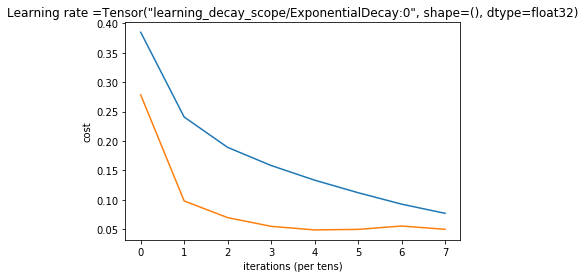

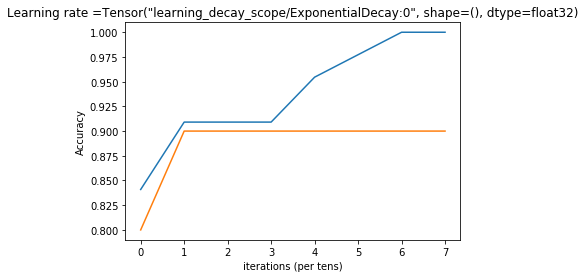

costs_train
[0.3847004945079486, 0.24066918405393758, 0.18912386863181987, 0.1583417085930705, 0.13345306797418743, 0.1121533843591654, 0.09271663235267624, 0.07713035843941422]
costs_dev
[0.2783438637852669, 0.0981187941506505, 0.06983185233548284, 0.05499307136051357, 0.04893635492771864, 0.049833838536869735, 0.0555673548951745, 0.0499731644813437]
{'b1': array([[-1.2804099],
       [-1.6186469],
       [ 2.2878623],
       [ 1.5170518],
       [ 1.7652676],
       [-1.6577206]], dtype=float32), 'W2': array([[-0.44200975, -0.79095656,  1.1529416 ,  0.31885248,  0.6298115 ,
        -1.0769932 ],
       [ 1.1350807 ,  0.8584715 , -0.2679392 , -0.9258422 , -1.0764023 ,
         1.1666763 ]], dtype=float32), 'W1': array([[ 0.55503106, -0.543895  , -0.9715043 , -0.5816937 , -0.17258978],
       [-0.1613934 ,  0.36285913, -1.3397902 , -0.8275129 ,  0.8600354 ],
       [ 0.20387343, -0.33715278,  0.13259849, -0.48451272, -0.3983989 ],
       [ 0.5201027 , -0.6587008 ,  0.41840103, -0.74405

In [21]:
# NOTE1: Whenever you need to use the framework, you need to update the list of record_defaults that defines
# default values for empty cells in the csv file. Go to decode_csv file to update it.
# NOTE2: Only numerical data is supported right now in the excel file.

# RUN AND TRAIN THE MODEL...

mu, sigma_square = get_input_norm_params(NORMALIZE_INPUT)

parameters = nn_model(mu, sigma_square)

print(parameters)

In [24]:
#TODO
# Implement accuracy calculation (on train and test sets)  -- DONE!
# Implement using CSV file(s) even for test data to calculate test accuracy  - DONE!
# Add batch normalization   -- DONE!
# Dropout   -- DONE!
# Add normalization to input params in layer=0  -- DONE!
# For softmax classification particularly, let label be 1 single column and generate the corresponding Y vectors dynamically 
# in the program -- DONE!
# Learning decay -- DONE!
# Accuracy calculation updated with tf.metrics.accuracy() -- DONE!
# Implement F1 Score, Precision, and Recall PER CLASS (num_classes can be more than 2)  -- DONE!
# Can we use tf.layers.dense(...) for forward propagation?
# Check tensorboard and if you have given appropriate names to your tensors
# Can we use ELU instead of RELU? ELU function has a parameter called alpha that needs to be tuned. The common 
# practice for ELU is to set alpha to 1. (Probably changing it doesnt give that much gain)
# Implement a new program that restores the latest model, takes an input and makes a prediction


abc = []
abc.append(1)
abc.append(5)
print(abc)
print(sum(abc))

[1, 5]
6


In [114]:
der = np.array([3,3,3])
print(len(der))

3
